In [1]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_fscore_support
import cv2 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:

# Define data folder and tumor types
data_folder = "/kaggle/input/brain-tumor"
tumor = ["glioma", "meningioma", "pituitary"]

# Define functions for image preprocessing
def preprocess_image(img_path, resize_dim=(224, 224), convert_to_gray=False):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is not None:
        if convert_to_gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if resize_dim:
            img = cv2.resize(img, resize_dim)      
    return img
def load_images_from_folder(folder, resize_dim=(224, 224), convert_to_gray=False):
    images = []
    labels = []
    for tumor_type_idx, tumor_type in enumerate(tumor, start=1):
        tumor_folder = os.path.join(folder, str(tumor_type_idx))
        for filename in tqdm(os.listdir(tumor_folder), desc=f"Loading {tumor_type} images"):
            img_path = os.path.join(tumor_folder, filename)
            img = preprocess_image(img_path, resize_dim=resize_dim, convert_to_gray=convert_to_gray)
            if img is not None:
                images.append(img)
                labels.append(tumor_type)
    return images, labels

In [3]:
# Load and preprocess images
images, labels = load_images_from_folder(data_folder, resize_dim=(224, 224), convert_to_gray=True)

# Convert images to RGB if they are in grayscale
rgb_img = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in images]

# Convert lists to NumPy arrays
images_array = np.array(rgb_img)
labels_array = np.array(labels)

Loading pituitary images: 100%|██████████| 930/930 [00:17<00:00, 53.52it/s]


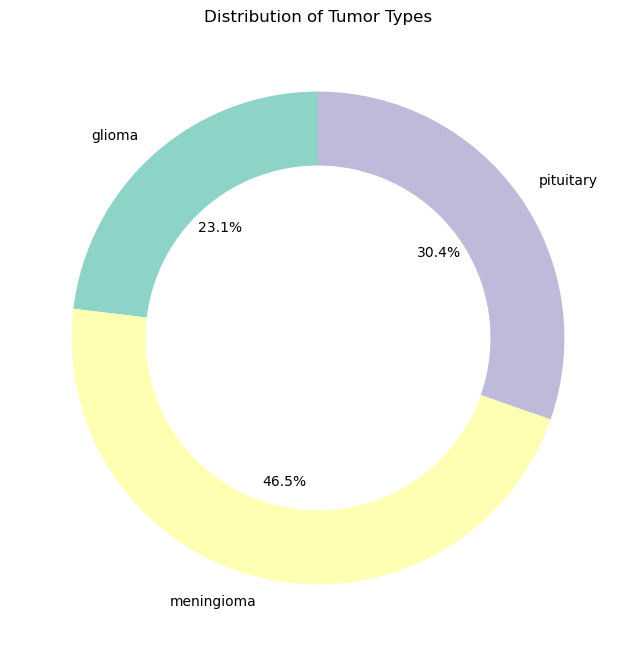

In [4]:
unique_labels, counts = np.unique(labels_array, return_counts=True)

# Create a donut plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Tumor Types')

plt.show()

In [5]:
images, labels = load_images_from_folder(data_folder)

Loading pituitary images: 100%|██████████| 930/930 [00:09<00:00, 96.09it/s]


In [6]:
#Split Dataset into Training and Testing Sets
train_images, test_images, train_labels, test_labels = train_test_split(rgb_img, labels, test_size=0.2, random_state=42, stratify=labels)

In [7]:

# Load the VGG16 model
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=len(tumor)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the top layers for classification
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the model
model = create_vgg16_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [8]:
#Convert labels to one-hot encoded vectors
label_binarizer = LabelBinarizer()
train_labels_one_hot = label_binarizer.fit_transform(train_labels)
test_labels_one_hot = label_binarizer.transform(test_labels)

In [9]:
# Train the model
model.fit(np.array(train_images), train_labels_one_hot, epochs=10, batch_size=35, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 461s 8s/step - loss: 8.1672 - accuracy: 0.7189 - val_loss: 0.4575 - val_accuracy: 0.8635
Epoch 2/10
56/56 [==============================] - 461s 8s/step - loss: 0.4913 - accuracy: 0.8617 - val_loss: 0.2923 - val_accuracy: 0.8778
Epoch 3/10
56/56 [==============================] - 464s 8s/step - loss: 0.3261 - accuracy: 0.8673 - val_loss: 0.2886 - val_accuracy: 0.8758
Epoch 4/10
56/56 [==============================] - 462s 8s/step - loss: 0.2863 - accuracy: 0.8862 - val_loss: 0.2336 - val_accuracy: 0.9022
Epoch 5/10
56/56 [==============================] - 463s 8s/step - loss: 0.2356 - accuracy: 0.8959 - val_loss: 0.2875 - val_accuracy: 0.9084
Epoch 6/10
56/56 [==============================] - 462s 8s/step - loss: 0.2340 - accuracy: 0.9051 - val_loss: 0.2136 - val_accuracy: 0.9246
Epoch 7/10
56/56 [==============================] - 463s 8s/step - loss: 0.2046 - accuracy: 0.9143 - val_loss: 0.2162 - val_accuracy: 0.9185
Epoch 8/10
56

In [10]:
test_loss, test_accuracy = model.evaluate(np.array(test_images), test_labels_one_hot)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

20/20 [==============================] - 115s 6s/step - loss: 0.2550 - accuracy: 0.9184
Test Loss: 0.2550, Test Accuracy: 0.9184


In [11]:

model.save('trained_model.h5')
loaded_model = load_model('trained_model.h5')